## Analysis Notebook 

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set professional style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.dpi'] = 120

# Load Data
try:
    df = pd.read_csv('../data/processed/model_metrics.csv')
    print(f"✅ Loaded metrics for {len(df)} coins.")
except FileNotFoundError:
    print("❌ Error: model_metrics.csv not found. Run evaluate.py first!")

# Peak at the raw data
df.head()

✅ Loaded metrics for 30 coins.


,Symbol,Base_RMSE,Base_MAE,Base_MAPE,Base_DirAcc,GNN_RMSE,GNN_MAE,GNN_MAPE,GNN_DirAcc,BIGNN_RMSE,BIGNN_MAE,BIGNN_MAPE,BIGNN_DirAcc
0,AAVE,13.912823,8.077065,4.221381,48.156551,13.437600,7.980379,4.230724,48.156551,13.163512,8.035447,4.445872,48.326716
1,ADA,0.054089,0.031297,3.823149,49.801475,0.056542,0.035466,4.482779,49.177538,0.052193,0.032137,4.263684,49.574589
2,ASTER,0.560493,0.121321,10.863884,1.871809,0.258596,0.062686,7.819906,1.644923,0.293459,0.065111,7.188115,1.928531
3,AVAX,2.648049,1.561034,4.670872,49.971639,2.664407,1.648519,5.046560,50.085082,2.574351,1.593161,5.097742,49.574589
4,BCH,28.581980,13.866951,3.436032,46.228020,28.915292,15.567657,3.934462,46.114577,27.080523,14.401485,4.066409,46.511628


In [12]:
def print_win_rate(name, imp_col):
    wins = len(df[df[imp_col] > 0])
    rate = (wins / len(df)) * 100
    print(f"{name} Win Rate: {rate:.1f}% (Better than Baseline)")

print("--- RMSE Win Rates (Lower Error) ---")
print_win_rate("LSTM-GNN", "GNN_Imp_RMSE")
print_win_rate("Bi-LSTM-GNN", "BiGNN_Imp_RMSE")

print("\n--- Directional Accuracy Win Rates (Better Trend Prediction) ---")
print_win_rate("LSTM-GNN", "GNN_Imp_Dir")
print_win_rate("Bi-LSTM-GNN", "BiGNN_Imp_Dir")

# Average Performance
avg_imp_gnn = df['GNN_Imp_RMSE'].mean()
avg_imp_bi = df['BiGNN_Imp_RMSE'].mean()

print(f"\nAverage Error Reduction: GNN={avg_imp_gnn:.2f}% | Bi-GNN={avg_imp_bi:.2f}%")

--- RMSE Win Rates (Lower Error) ---
LSTM-GNN Win Rate: 53.3% (Better than Baseline)
Bi-LSTM-GNN Win Rate: 70.0% (Better than Baseline)

--- Directional Accuracy Win Rates (Better Trend Prediction) ---
LSTM-GNN Win Rate: 66.7% (Better than Baseline)
Bi-LSTM-GNN Win Rate: 66.7% (Better than Baseline)

Average Error Reduction: GNN=-0.76% | Bi-GNN=-4.42%


/tmp/ipykernel_3054439/1210029376.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_df, x='Model', y='MAPE', palette=['orange', 'cyan', 'magenta'])


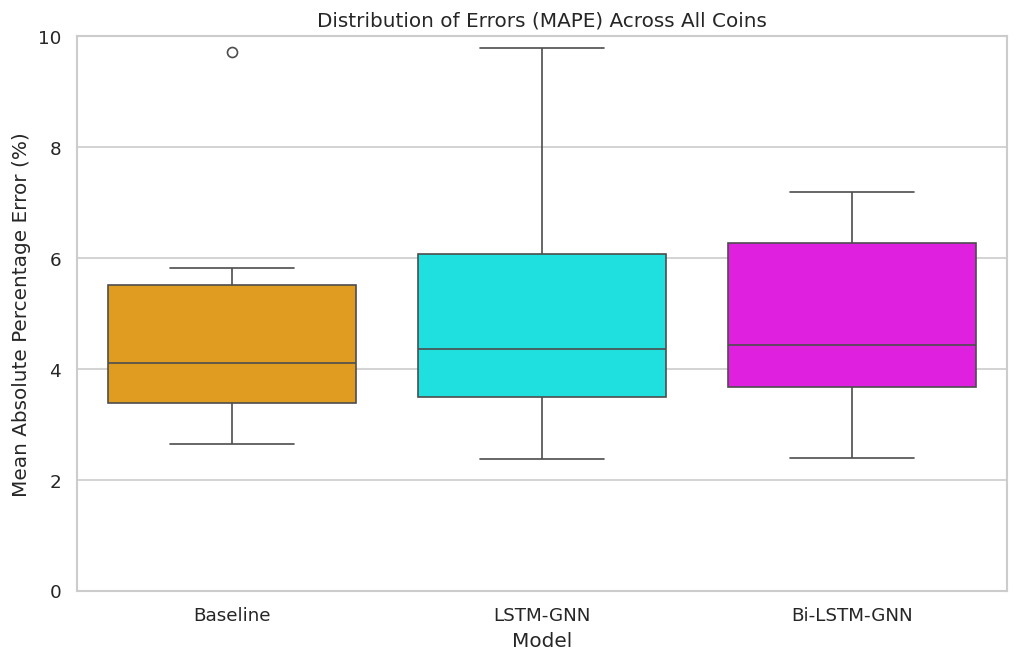

In [13]:
# Melt dataframe for seaborn plotting
plot_df = df.melt(value_vars=['Base_MAPE', 'GNN_MAPE', 'BIGNN_MAPE'], 
                  var_name='Model', value_name='MAPE')

# Rename labels for cleaner plot
plot_df['Model'] = plot_df['Model'].map({
    'Base_MAPE': 'Baseline',
    'GNN_MAPE': 'LSTM-GNN',
    'BIGNN_MAPE': 'Bi-LSTM-GNN'
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=plot_df, x='Model', y='MAPE', palette=['orange', 'cyan', 'magenta'])
plt.title("Distribution of Errors (MAPE) Across All Coins")
plt.ylabel("Mean Absolute Percentage Error (%)")
plt.ylim(0, 10) # Zoom in to 0-10% range to ignore extreme outliers
plt.show()

/tmp/ipykernel_3054439/1461424333.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sorted.head(20), x='Symbol', y='RMSE_Improvement_Pct', palette='viridis')


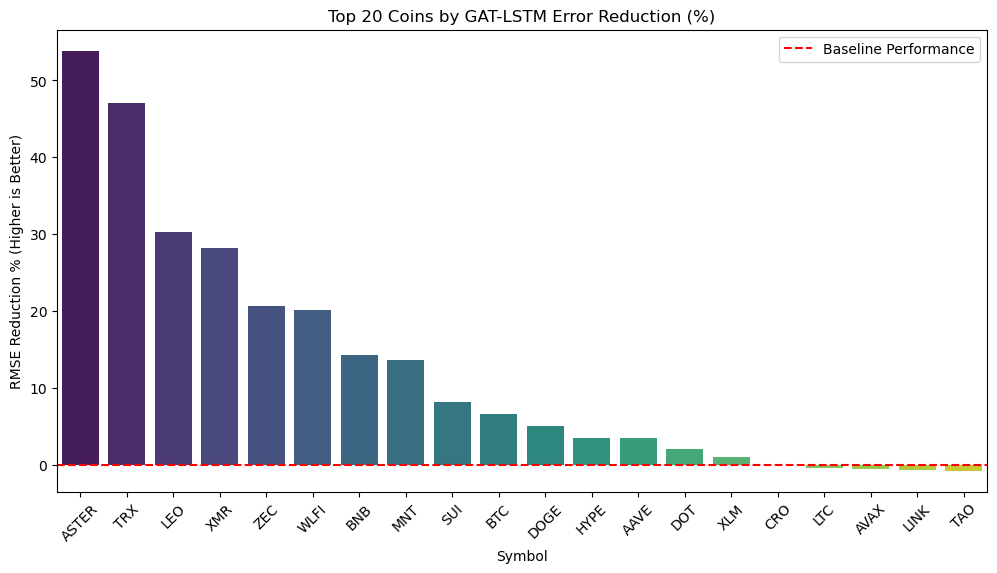

In [8]:
# Sort by Market Cap or just Improvement
df_sorted = df.sort_values('RMSE_Improvement_Pct', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=df_sorted.head(20), x='Symbol', y='RMSE_Improvement_Pct', palette='viridis')
plt.title("Top 20 Coins by GAT-LSTM Error Reduction (%)")
plt.ylabel("RMSE Reduction % (Higher is Better)")
plt.xticks(rotation=45)
plt.axhline(0, color='red', linestyle='--', label="Baseline Performance")
plt.legend()
plt.show()

## Does GNN help more volatile coins?

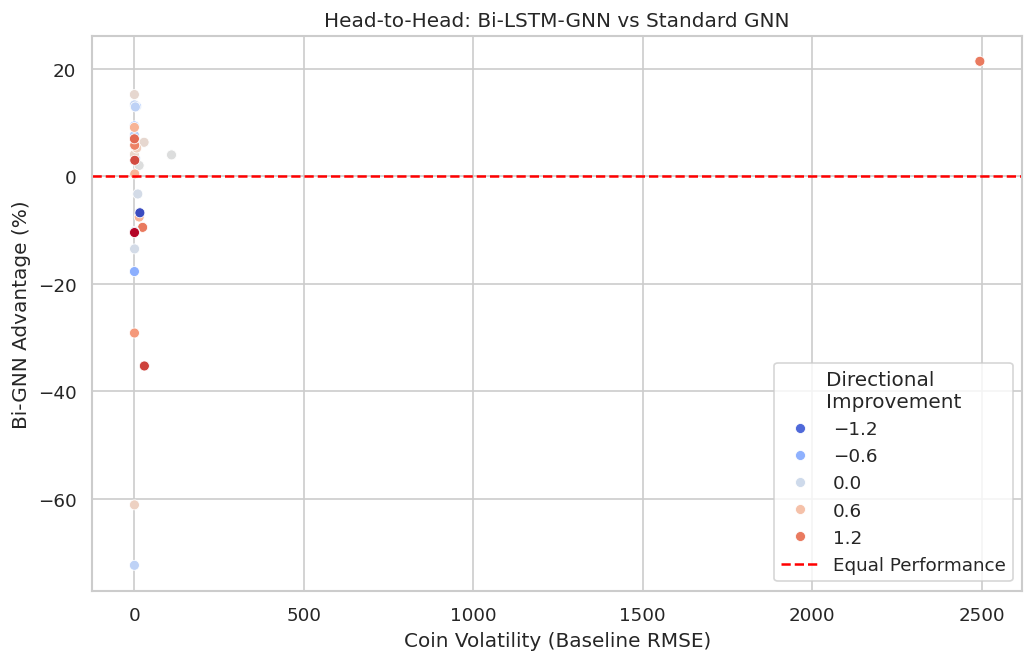

In [14]:
plt.figure(figsize=(10, 6))

# X-axis: How volatile/expensive was the coin? (Baseline Error is a proxy for volatility)
# Y-axis: How much better is Bi-GNN than standard GNN?
sns.scatterplot(data=df, x='Base_RMSE', y='Bi_vs_Mono_Imp', hue='BiGNN_Imp_Dir', palette='coolwarm')

plt.title("Head-to-Head: Bi-LSTM-GNN vs Standard GNN")
plt.xlabel("Coin Volatility (Baseline RMSE)")
plt.ylabel("Bi-GNN Advantage (%)")
plt.axhline(0, color='red', linestyle='--', label="Equal Performance")
plt.legend(title="Directional\nImprovement")
plt.show()

In [ ]:
import torch
!pip install torchviz
from torchviz import make_dot
from models.lstm_gnn import DeepBiLSTMGNN

# 1. Setup Dummy Data
# Batch=1, Window=60, Nodes=10, Features=6
x = torch.randn(1, 60, 10, 6) 
# Adj matrix: Batch=1, Window=60, Nodes=10, Nodes=10
adj = torch.randn(1, 60, 10, 10)

# 2. Initialize Model
model = DeepBiLSTMGNN(num_nodes=10, in_channels=6, hidden_dim=32)

# 3. Forward Pass
y = model(x, adj)

# 4. Generate Graph
dot = make_dot(y, params=dict(model.named_parameters()), show_attrs=True, show_saved=True)
dot.format = 'png'
dot.render("bi_lstm_gnn_architecture")

print("Saved bi_lstm_gnn_architecture.png")

SyntaxError: invalid syntax (416492793.py, line 4)